# Richards' equation

* Author: Jhabriel Varela
* E-mail: jhabriel.varela@uib.no
* Date: 04.04.2019
* Institution: PMG - UiB - Norway

## Description of the problem

In this tutorial, we show how to implement the incompressible Richards' equation in a pseudo one-dimensional domain using MPFA and automatic differentiation. 

### Governing equations in the continuous domain

The governing equations can be split into two PDEs, the mass conservation and Darcy's law. 

* The mass conservation equation can be stated as

$$
  \frac{\partial \theta}{\partial t} + \nabla \cdot \mathbf{q} = f,
$$

where $\theta$ is the water content, $\underline{q}$ is the water Darcy's velocitiy and $f$ is an external source term.

* The Darcy's velocity is given by

$$
\mathbf{q} = - \frac{\rho g}{\mu} K k_r^w \nabla h,
$$

where $\rho$ is the water density, $g$ is the gravity acceleration, $\mu$ is the water viscosity, $K$ is the permeability tensor, $k_r^w$ is the relative permeability and $h$ is the hydraulic head [[1](#ref)].  

### Governing equations in the discrete domain

In this example, we use CCFV-MPFA (Cell Centered Finite Volume - Multi-Point Flux Approximation) to discretize the set of PDE's [[2](#ref)]. Moreover, we make use of the discrete operators such as divergence, gradient and so on, to represent the mapping between vector spaces (centers and faces) [[3](#ref)]. After the discretization process, we obtain the following discrete equations.

* Discrete mass conservation equation 

$$
\frac{[V]_{\mathtt{c}}}{\tau^{\mathtt{n}}} \left([\theta]^{\mathtt{n+1,m}}_{\mathtt{c}} + [C]^{\mathtt{n+1,m}}_{\mathtt{c}}   \left([h]_{\mathtt{c}}^{\mathtt{n+1,m+1}} - [h]_{\mathtt{c}}^{\mathtt{n+1,m}}\right) - [\theta]_{\mathtt{c}}^{\mathtt{n}}\right) + \mathbf{div}\left( [Q]_{\mathtt{f}} \right)_{\mathtt{c}} = [V]_{\mathtt{c}} [f]_{\mathtt{c}},
$$   
where $\tau$ is the time step, $\mathbf{C}$ is the specific moisture capacity, $\mathbf{V}$ corresponds to the cell volumes and $\mathbf{Q}$ is the (volumetric water) flux.

* Discrete Darcy's law

$$
[Q]_\mathtt{f} = \frac{\rho g}{\mu} \left[{\bar{k}_r^w}\right]^{\mathtt{n+1,m}}_{\mathtt{f}} \left( \mathbf{F}\left([{h}]^{\mathtt{n+1,m+1}}_{\mathtt{c}}\right)_{\mathtt{f}} + \mathbf{boundF}\left([{b}]_{\mathtt{f}}\right)_{\mathtt{f}} \right),
$$

where $[{b}]$ is the vector of boundary conditions (containing both, Dirichlet and Neumann bc's). Note that the quantities in square brackets represent vector quantities in a computational sense. 

The subinidices $\mathtt{c}$ and $\mathtt{f}$ denote cell-centered and face-centered evaluations, respectively. And the superindices $\mathtt{n}$ and $\mathtt{m}$ denote time and iteration levels.

The relative permeabilities must be evaluated at the faces centroids. To do this, we perform an arithmetic average using the information available at the cell centers. This is indicated by using $\bar{k}_r^w$.

In this example, we make use of three discrete operators: the $\mathbf{div}$ operator, which is the scalar divergence operator (that maps from faces to centers), the $\mathbf{F}$ operator, which is the flux operator (that maps from centers to faces) and the $\mathbf{boundF}$ operator (that maps from faces to faces) which deals with the boundary contributions. 

### Water retention curves

The water content $\theta$, relative permeability $k_r^w$ and specific moisture capacity $C$ are often represented as (non-linear) functions of the water pressure head $\psi$. Using the van Genuchten water retention curves [[4](#ref)], these functions have the following forms

$$
\theta = \begin{cases} 
\displaystyle{\frac{\theta_s - \theta_r}{[1+(\alpha_v |\psi|)^{n_v}]^{m_v}}} & \psi < 0 \\
\theta_s & \psi \geq 0
\end{cases},
$$

$$
k_r^w = \begin{cases}
\displaystyle{\frac{\bigl\{ 1 - (\alpha_v |\psi|)^{n_v-1} \left[1 + (\alpha_v |\psi|^{n_v}) \right]^{-m_v}\bigr\}^2}{\left[1 + (\alpha_v |\psi|)^{n_v} \right]^{m_v/2}}} & \psi < 0 \\
1 & \psi \geq 0 
\end{cases},
$$

$$
C = \begin{cases}
\displaystyle{- \frac{m_v n_v \psi (\theta_s - \theta_r) (\alpha_v |\psi|)^{n_v}}{|\psi_w|^2 \left[ (\alpha_v |\psi|)^{n_v} +1 \right]^{m_v+1}}} & \psi < 0 \\
0 & \psi \geq 0
\end{cases}
$$


In these functions, $\theta_s$ and $\theta_r$ denote the water content at saturated conditions and the residual water content. Moreover, $\alpha_v$, $n_v$ and $m_v$ are the van Genuchten fitting parameteres of the water retention curve.

### The problem to be solved

In this example, we simulate a water infiltration process (from top to bottom) in an originally dry soil. For this purpose, we use a three-dimensional domain of size $100\times 100\times 100 \, [cm^3]$, with their corresponding number of cells in each direction: $[5,5,30]$. 

The boundary conditions are imposed at the bottom and top of the domain as constant pressure heads: $\psi(0,0,0,t) = -1000 \, [cm]$ and $\psi(0,0,100,t) = -75 \, [cm]$. The rest of the boundaries are set as no flux. The initial condition is set to $\psi(x,y,z,0) = -1000 \, [cm]$ and we assume $f= 0$.

## Importing modules and external functions

In [1]:
import numpy as np
import scipy.sparse as sps
import porepy as pp
import matplotlib.pyplot as plt

from porepy.ad.forward_mode import Ad_array
from functions_re import arithmetic_mpfa_hyd
from functions_re import time_stepping
from functions_re import newton_solver
from functions_re import save_solution

np.set_printoptions(precision=4, suppress = True)

## Setting up the grid

In [2]:
Nx = 5;  Ny = 5;  Nz = 30
Lx = 10; Ly = 10; Lz = 100
g = pp.CartGrid([Nx,Ny,Nz], [Lx,Ly,Lz])
g.compute_geometry()
V = g.cell_volumes

## Physical properties
The set of physical properties was taken from [[1](#ref)]

### Fluid properties

In [3]:
fluid = dict()
fluid['density'] = 1.0       # [g/cm^3]
fluid['viscosity'] = 0.01    # [g/cm.s]
fluid['gravity'] = 980.6650  # [cm/s^2]

### Porous medium properties

In [4]:
medium = dict()
medium['sat_hyd_cond'] = 0.00922 # Saturated hydraulic conductivity [cm/s]

### Rock properties

In [5]:
rock = dict()
rock['permeability'] = (medium['sat_hyd_cond']*fluid['viscosity']) / \
                       (fluid['density']*fluid['gravity']) # [cm^2]
# Creating the permeability second order tensor                       
perm = pp.SecondOrderTensor(g.dim, rock['permeability'] * np.ones(g.num_cells))

### van Genuchten parameters

In [6]:
van_gen = dict()
van_gen['alpha'] = 0.0335            # [1/cm] equation parameter
van_gen['n'] = 2.0                   # [-] equation parameter
van_gen['m'] = 1-(1/van_gen['n'])    # [-] equation parameter
van_gen['theta_s'] = 0.368           # [-] water content at saturated conditions
van_gen['theta_r'] = 0.102           # [-] residual water content

## Boundary and initial conditions

In [7]:
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]

# Extracting grid information
z_cntr = g.cell_centers[2,:]
z_fcs = g.face_centers[2,:]

# Extracting indices of boundary faces w.r.t g
x_min = b_faces[g.face_centers[0,b_faces] < 0.0001]
x_max = b_faces[g.face_centers[0,b_faces] > 0.9999*Lx]
y_min = b_faces[g.face_centers[1,b_faces] < 0.0001]
y_max = b_faces[g.face_centers[1,b_faces] > 0.9999*Ly]
z_min = b_faces[g.face_centers[2,b_faces] < 0.0001]
z_max = b_faces[g.face_centers[2,b_faces] > 0.9999*Lz]

# Extracting indices of boundary faces w.r.t b_faces
east   = np.in1d(b_faces,x_min).nonzero()
west   = np.in1d(b_faces,x_max).nonzero()
south  = np.in1d(b_faces,y_min).nonzero()
north  = np.in1d(b_faces,y_max).nonzero()
bottom = np.in1d(b_faces,z_min).nonzero()
top    = np.in1d(b_faces,z_max).nonzero()

# Setting the tags at each boundary side
labels = np.array([None]*b_faces.size)
labels[east]   = 'neu'
labels[west]   = 'neu'
labels[south]  = 'neu'
labels[north]  = 'neu'
labels[bottom] = 'dir'
labels[top]    = 'dir'

# Constructing the bc object
bc = pp.BoundaryCondition(g, b_faces, labels)

# Imposed pressures and fluxes at the boundaries
flux_west = 0       # [cm^3/s] 
fluw_east = 0       # [cm^3/s]
flux_south = 0      # [cm^3/s]
flux_north = 0      # [cm^3/s]
psi_top = -75       # [cm]
psi_bottom = -1000  # [cm]

h_top = psi_top + z_fcs[z_max]       # [cm] top hyd head
h_bottom = psi_bottom + z_fcs[z_min] # [cm] bottom hyd head

# Constructing the boundary values array
bc_val = np.zeros(g.num_faces)
bc_val[x_min] = np.zeros(x_min.size)
bc_val[x_max] = np.zeros(x_max.size)
bc_val[y_min] = np.zeros(y_min.size)
bc_val[y_max] = np.zeros(y_max.size)
bc_val[z_min] = h_bottom * np.ones(z_min.size)
bc_val[z_max] = h_top * np.ones(z_max.size)

# Initial condition
h_init = psi_bottom + z_cntr

## Creating the data object

In [8]:
specified_parameters = {"second_order_tensor": perm, 
                        "bc": bc, 
                        "bc_values": bc_val}

data = pp.initialize_default_data(g,{},"flow", specified_parameters)

## Performing the discretization using MPFA

In [9]:
# Instatiating the pp.Mpfa class
solver = pp.Mpfa("flow")

# MPFA discretization
mpfa_F, mpfa_boundF, _, _ = solver.mpfa(g, perm, bc)
mpfa_div = pp.fvutils.scalar_divergence(g)

## Creating MPFA discrete operators

In [10]:
F      = lambda x: mpfa_F * x
boundF = lambda x: mpfa_boundF * x
div    = lambda x: mpfa_div * x

## Water retention curves

*Please note that $\psi$ must be passed in centimeters*

In [11]:
# Boolean lamdba-function which determines sat or unsat condition
is_unsat = lambda psi: psi < 0

# Water content
theta = lambda psi: is_unsat(psi) * ( (van_gen['theta_s'] - van_gen['theta_r']) / 
                    (1. + (van_gen['alpha'] * np.abs(psi))**van_gen['n'])**van_gen['m'] + 
                    van_gen['theta_r']) + (1-is_unsat(psi))*van_gen['theta_s']

# Specific moisture capacity
C = lambda psi: is_unsat(psi) * ( (van_gen['m'] * van_gen['n'] * psi * 
                (van_gen['theta_r']-van_gen['theta_s']) * 
                van_gen['alpha']**van_gen['n'] * np.abs(psi)**(van_gen['n']-2.) ) /
                (van_gen['alpha']**van_gen['n'] * np.abs(psi)**van_gen['n'] + 1.) ** 
                (van_gen['m']+1.)) + (1-is_unsat(psi)) * 0

# Relative permeability
krw = lambda psi: is_unsat(psi)*((1. - (van_gen['alpha'] * np.abs(psi)) **
                  (van_gen['n']-1) * (1. + (van_gen['alpha'] * np.abs(psi)) ** 
                  van_gen['n'])**(-van_gen['m']))**2. /
                  (1. + (van_gen['alpha'] * np.abs(psi)) ** van_gen['n']) ** 
                  (van_gen['m']/2.)) + (1-is_unsat(psi)) * 1.

## Discrete equations

When we perform arithmetic operations involving a np.array and an AD Porepy 
object, the array must be always located at the right of the AD Porepy object.
This behaviour has its root on the way NumPy perform multiplication
between objects of different size, the so called broadcasting property. 
Alternatively, we could create SciPy diagonal (sparse) matrices. 
However, what we can win from keeping the original structure of the equations,
is completely lost due to the lack of readibility.

In [12]:
# Arithmetic mean of relative permeability
krw_ar = lambda h_m: arithmetic_mpfa_hyd(krw,g,bc,bc_val,h_m)

# Multiphase Darcy Flux
q = lambda h,h_m: (fluid['density']*fluid['gravity']/fluid['viscosity']) * \
                   (F(h) + boundF(bc_val)) * krw_ar(h_m)

# Mass Conservation
h_eq = lambda h,h_n,h_m,dt: div(q(h,h_m)) +  ((h-h_m)*C(h_m-z_cntr) + 
                                              theta(h_m-z_cntr) - 
                                              theta(h_n-z_cntr)) * (V/dt)              

## Creating the AD-object

In [13]:
h_ad = Ad_array(h_init.copy(), sps.diags(np.ones(g.num_cells)))

## Time, solver, printing and solution dictionaries

In [14]:
# Time parameters
time_param = dict()                       # initializing time parameters dictionary
time_param['sim_time'] = 72 * 3600        # [s] final simulation time
time_param['dt_init'] = 100               # [s] initial time step
time_param['dt_min'] = 100                # [s] minimum time step
time_param['dt_max'] = 10000              # [s] maximum time step
time_param['lower_opt_iter_range'] = 3    # [iter] lower optimal iteration range
time_param['upper_opt_iter_range'] = 7    # [iter] upper optimal iteration range
time_param['lower_mult_factor'] = 1.3     # [-] lower multiplication factor
time_param['upper_mult_factor'] = 0.7     # [-] upper multiplication factor
time_param['dt'] = time_param['dt_init']  # [s] initializing time step
time_param['dt_print'] = time_param['dt'] # [s] initializing printing time step
time_param['time_cum'] = 0                # [s] cumulative time

# Newton parameters
newton_param = dict()
newton_param['max_tol'] = 1               # [cm] maximum absolute tolerance (pressure head)
newton_param['max_iter'] = 10             # [iter] maximum number of iterations
newton_param['abs_tol'] = 100             # [cm] absolute tolerance
newton_param['iter'] = 1                  # [iter] iteration

# Printing parameters
print_param = dict()
print_param['levels'] = 10                # number of printing levels
print_param['times'] = np.linspace(time_param['sim_time']/print_param['levels'], \
                       time_param['sim_time'],print_param['levels'])
print_param['counter'] = 0                # initializing printing counter
print_param['is_active'] = False          # Printing = True; Not Printing = False

# Solution dictionary
sol = dict()
sol['time'] = np.zeros((print_param['levels']+1,1))
sol['hydraulic_head'] = np.zeros((print_param['levels']+1,g.num_cells))
sol['pressure_head'] = np.zeros((print_param['levels']+1,g.num_cells))
sol['elevation_head'] = np.zeros((print_param['levels']+1,g.num_cells))
sol['water_content'] = np.zeros((print_param['levels']+1,g.num_cells))
sol['darcy_fluxes'] = np.zeros((print_param['levels']+1,g.num_faces))
sol['iterations'] = np.array([],dtype=int)
sol['time_step'] = np.array([],dtype=float)
# Saving inital conditions
save_solution(sol,newton_param,time_param,print_param,g,h_ad,h_ad,theta,q)

## The time loop

In [15]:
while time_param['time_cum'] < time_param['sim_time']:
        
    if print_param['is_active'] == False:
        
        h_n = h_ad.val.copy()                                     # current time level (n)
        time_param['time_cum'] += time_param['dt'] 
        newton_param.update({'abs_tol':100, 'iter':1})            # updating tolerance and iterations
        
        # Newton loop
        while newton_param['abs_tol'] > newton_param['max_tol']   and \
              newton_param['iter']    < newton_param['max_iter']:      
              
            h_m = h_ad.val.copy()                               # current iteration level (m)
            eq = h_eq(h_ad,h_n,h_m,time_param['dt'])            # calling discrete equation
            newton_solver(eq,h_ad,h_m,newton_param,time_param,print_param)  # calling newton solver
        
        # Calling time stepping routine
        time_stepping(time_param,newton_param,print_param)
        
        # Determining if next step we should print or not
        if time_param['dt'] + time_param['time_cum'] >= print_param['times'][print_param['counter']]:
            
            time_param['dt_print'] = print_param['times'][print_param['counter']] - time_param['time_cum']
            print_param['is_active'] = True
        
    elif print_param['is_active'] == True:
        
        h_ad_print = Ad_array(h_ad.val.copy(), sps.diags(np.ones(g.num_cells)))
        h_n_print = h_ad_print.val.copy()
        newton_param.update({'abs_tol':100, 'iter':1})            # updating tolerance and iterations
        
        # Newton loop
        while newton_param['abs_tol'] > newton_param['max_tol']   and \
              newton_param['iter']    < newton_param['max_iter']:      
              
            h_m_print = h_ad_print.val.copy()                                           # current iteration level (m)
            eq = h_eq(h_ad_print,h_n_print,h_m_print,time_param['dt_print'])            # calling discrete equation
            newton_solver(eq,h_ad_print,h_m_print,newton_param,time_param,print_param)  # calling newton solver
        
        print_param['is_active'] = False                          # Deactivating printing mode
        
        # Determining if we reach the end of the simulation or not
        if time_param['time_cum'] + time_param['dt_print'] == time_param['sim_time']:
            
            print('---- End of simulation ----')
            break
        
    # Saving solutions
    save_solution(sol,newton_param,time_param,print_param,g,h_ad,h_m,theta,q)    

Time: 100.00 [s] 	 Iter: 7 	 Error: 0.564 [cm]
Time: 200.00 [s] 	 Iter: 5 	 Error: 0.602 [cm]
Time: 300.00 [s] 	 Iter: 4 	 Error: 0.841 [cm]
Time: 400.00 [s] 	 Iter: 5 	 Error: 0.070 [cm]
Time: 500.00 [s] 	 Iter: 5 	 Error: 0.114 [cm]
Time: 600.00 [s] 	 Iter: 5 	 Error: 0.130 [cm]
Time: 700.00 [s] 	 Iter: 4 	 Error: 0.863 [cm]
Time: 800.00 [s] 	 Iter: 4 	 Error: 0.549 [cm]
Time: 900.00 [s] 	 Iter: 4 	 Error: 0.317 [cm]
Time: 1000.00 [s] 	 Iter: 4 	 Error: 0.174 [cm]
Time: 1100.00 [s] 	 Iter: 3 	 Error: 0.899 [cm]
Time: 1230.00 [s] 	 Iter: 4 	 Error: 0.114 [cm]
Time: 1360.00 [s] 	 Iter: 3 	 Error: 0.907 [cm]
Time: 1529.00 [s] 	 Iter: 4 	 Error: 0.611 [cm]
Time: 1698.00 [s] 	 Iter: 3 	 Error: 0.996 [cm]
Time: 1917.70 [s] 	 Iter: 5 	 Error: 0.036 [cm]
Time: 2137.40 [s] 	 Iter: 3 	 Error: 0.687 [cm]
Time: 2423.01 [s] 	 Iter: 5 	 Error: 0.136 [cm]
Time: 2708.62 [s] 	 Iter: 4 	 Error: 0.839 [cm]
Time: 2994.23 [s] 	 Iter: 4 	 Error: 0.460 [cm]
Time: 3279.84 [s] 	 Iter: 4 	 Error: 0.522 [cm]
T

Time: 159171.38 [s] 	 Iter: 4 	 Error: 0.205 [cm]
Time: 160549.96 [s] 	 Iter: 4 	 Error: 0.251 [cm]
Time: 161928.55 [s] 	 Iter: 3 	 Error: 0.958 [cm]
Time: 163720.71 [s] 	 Iter: 4 	 Error: 0.544 [cm]
Time: 165512.87 [s] 	 Iter: 4 	 Error: 0.464 [cm]
Time: 167305.03 [s] 	 Iter: 4 	 Error: 0.367 [cm]
Time: 169097.19 [s] 	 Iter: 4 	 Error: 0.411 [cm]
Time: 170889.35 [s] 	 Iter: 4 	 Error: 0.520 [cm]
Time: 172681.51 [s] 	 Iter: 4 	 Error: 0.527 [cm]
Time: 174473.67 [s] 	 Iter: 4 	 Error: 0.473 [cm]
Time: 176265.83 [s] 	 Iter: 4 	 Error: 0.388 [cm]
Time: 178057.99 [s] 	 Iter: 4 	 Error: 0.300 [cm]
Time: 179850.15 [s] 	 Iter: 4 	 Error: 0.458 [cm]
		 Saving solutions: 		
Time: 181440.00 [s] 	 Iter: 4 	 Error: 0.354 [cm]
Time: 181642.31 [s] 	 Iter: 4 	 Error: 0.507 [cm]
Time: 183434.47 [s] 	 Iter: 4 	 Error: 0.481 [cm]
Time: 185226.63 [s] 	 Iter: 4 	 Error: 0.413 [cm]
Time: 187018.79 [s] 	 Iter: 4 	 Error: 0.328 [cm]
Time: 188810.95 [s] 	 Iter: 4 	 Error: 0.420 [cm]
Time: 190603.11 [s] 	 Iter

## Plotting solutions

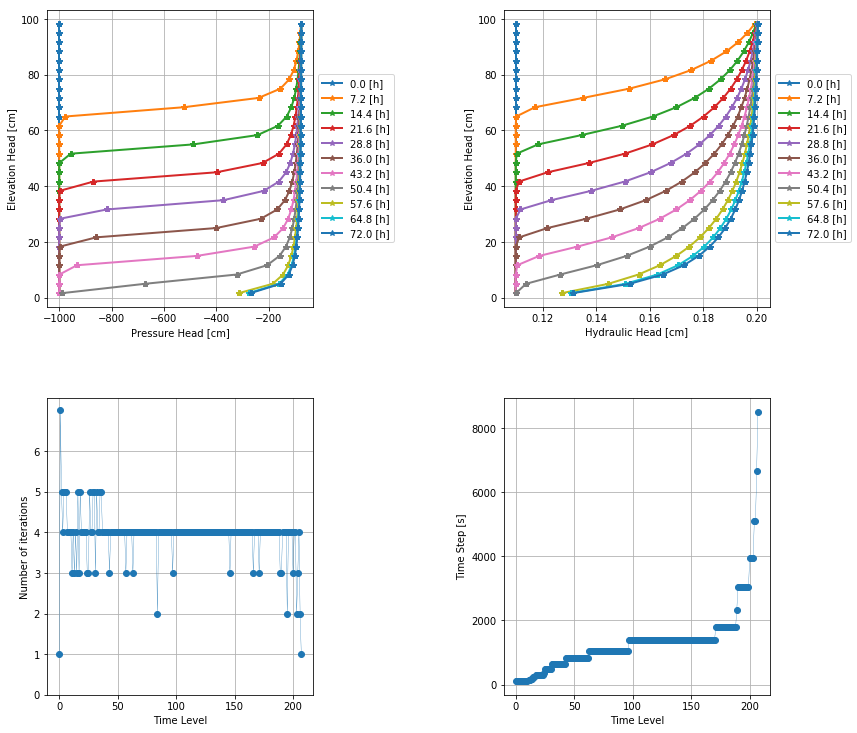

In [16]:
#%% Plotting results
fig = plt.figure(figsize=(15,12))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

for graph in range(len(sol['time'])):
    
    ax1.plot(sol['pressure_head'][graph],z_cntr,
             marker = '*', linewidth = 2,
             label=str(sol['time'][graph][0]/3600) + ' [h]')
    
    ax2.plot(sol['water_content'][graph],z_cntr,
             marker = '*', linewidth = 2,
             label=str(sol['time'][graph][0]/3600) + ' [h]')
    
ax3.plot(sol['iterations'],marker='o',linewidth=0.3)    
ax4.plot(sol['time_step'],marker='o',linewidth=0.3)

# Shrink current axis by 20%
box1 = ax1.get_position()
box2 = ax2.get_position()
box3 = ax3.get_position()
box4 = ax4.get_position()
ax1.set_position([box1.x0, box1.y0, box1.width * 0.7, box1.height])
ax2.set_position([box2.x0, box2.y0, box2.width * 0.7, box2.height])
ax3.set_position([box3.x0, box3.y0*0.7, box3.width * 0.7, box3.height])
ax4.set_position([box4.x0, box4.y0*0.7, box4.width * 0.7, box4.height])


# Put a legend to the right of the current axis
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Put axis labels
ax1.set_xlabel('Pressure Head [cm]')
ax1.set_ylabel('Elevation Head [cm]')
ax1.grid(True)  

ax2.set_xlabel('Hydraulic Head [cm]')
ax2.set_ylabel('Elevation Head [cm]')
ax2.grid(True)  

ax3.set_xlabel('Time Level')
ax3.set_ylabel('Number of iterations')
ax3.set_yticks([0,1,2,3,4,5,6])
ax3.grid(True)  

ax4.set_xlabel('Time Level')
ax4.set_ylabel('Time Step [s]')
ax4.grid(True)  

plt.show()

## References
<a id='ref'></a>

[1]: *Pinder, G. F., & Celia, M. A. (2006). Subsurface hydrology. John Wiley & Sons.*

[2]: *Aavatsmark, I. (2002). An introduction to multipoint flux approximations for quadrilateral grids. Computational Geosciences, 6(3-4), 405-432.*

[3]: *Varela, J. (2018). Implementation of an MPFA/MPSA-FV Solver for the Unsaturated Flow in Deformable Porous Media (Master's thesis, The University of Bergen).*

[4]: *Van Genuchten, M.T., 1980. A closed-form equation for predicting the hydraulic conductivity of unsaturated soils 1. Soil science society of America journal, 44(5), pp.892-898.*